# CTA data analysis with Gammapy

## Introduction

The focus of this notebook is on demonstrating how to quickly perform a standard analysis of a given target in the sky. The gammapy functions and classes that we'll use won't be explained in detail. Please refer to the other gammapy tutorial notebooks, if you're interested.

At some point there should be a convenience class to make this kind of analysis easier, feedback on how this should be implemented is welcome!

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions, if something goes wrong here you won't be able to run the notebook

import numpy as np
import astropy
import regions
import sherpa
import uncertainties

print('numpy:', np.__version__)
print('astropy:', astropy.__version__)
print('regions:', regions.__version__)
print('sherpa:', sherpa.__version__)
print('uncertainties:', uncertainties.__version__)

numpy: 1.12.0
astropy: 2.0.dev17848
regions: 0.2.dev360
sherpa: ciao4.9+1.g1ebebb7
uncertainties: 2.4.8.1


In [3]:
import logging
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion

from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
    )

from gammapy.image import SkyMask, SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator

from gammapy.extern.pathlib import Path
from gammapy.utils.energy import EnergyBounds

In [4]:
# Setup the logger
logging.basicConfig()
log = logging.getLogger('gammapy.spectrum')
log.setLevel(logging.ERROR)

In [5]:
import warnings; warnings.filterwarnings('ignore')

## Load Data

First, we have to load the CTA data exported to fits format (the format is described in detail [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/)).

In [6]:
DATA_DIR = '$GAMMAPY_EXTRA/test_datasets/cta_1dc'
# DATA_DIR = '/Users/deil/1dc/1dc.pre'

data_store = DataStore.from_dir(DATA_DIR)
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /Users/deil/code/gammapy-extra/test_datasets/cta_1dc
Rows: 10038
OBS_ID: 1 -- 1673
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Number of observations: 1673


In [7]:
print(data_store.obs_table.colnames)
obs_colnames = ['OBS_ID', 'DATE_OBS', 'TIME_OBS', 'GLON_PNT', 'GLAT_PNT']
data_store.obs_table[::100][obs_colnames]

['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE_OBS', 'TIME_OBS', 'DATE_END', 'TIME_END', 'EVENTS_FILENAME', 'EVENT_COUNT', 'EVENT_TIME_MIN', 'EVENT_TIME_MAX', 'EVENT_ENERGY_MIN', 'EVENT_ENERGY_MAX']


OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
1,2021-01-01,11:58:51,359.500044973,-0.500037206629
101,2021-01-06,14:38:51,359.850020073,-0.416645559074
201,2021-01-11,17:18:51,0.0999876586067,-0.333402059745
301,2021-01-16,19:58:51,0.449997382071,-0.250026911671
401,2021-01-22,12:30:51,359.749994512,-0.0833922689931
501,2021-01-27,15:10:51,359.999985804,-1.94251867121e-05
601,2021-02-01,17:50:51,0.34998366634,0.0832847289392
701,2021-02-06,20:30:51,359.650013181,0.249974821922
801,2021-02-12,13:02:51,359.900010511,0.333332196219


## Select observations

In [8]:
# I've only copied EVENTS for these three obs for testing
# Trying to access any other will fail!
obs_id = [659, 1398, 1320]
observation_list = data_store.obs_list(obs_id)

In [9]:
data_store.obs_table.select_obs_id(obs_id)[obs_colnames]

OBS_ID,DATE_OBS,TIME_OBS,GLON_PNT,GLAT_PNT
int64,str10,str8,float64,float64
659,2021-02-04,18:22:51,0.100058295405,0.166660969419
1398,2021-03-15,17:18:51,5.13611286693e-05,2.00001672658
1320,2021-03-11,16:14:51,3.07691727701,-0.66667119626


In [10]:
obs = observation_list[0]

In [11]:
print(obs)

Info for OBS_ID = 659
- Start time: 665735040.00
- Pointing pos: RA 266.30 deg / Dec -28.76 deg
- Observation duration: 1800.0 s
- Dead-time fraction: 5.000 %



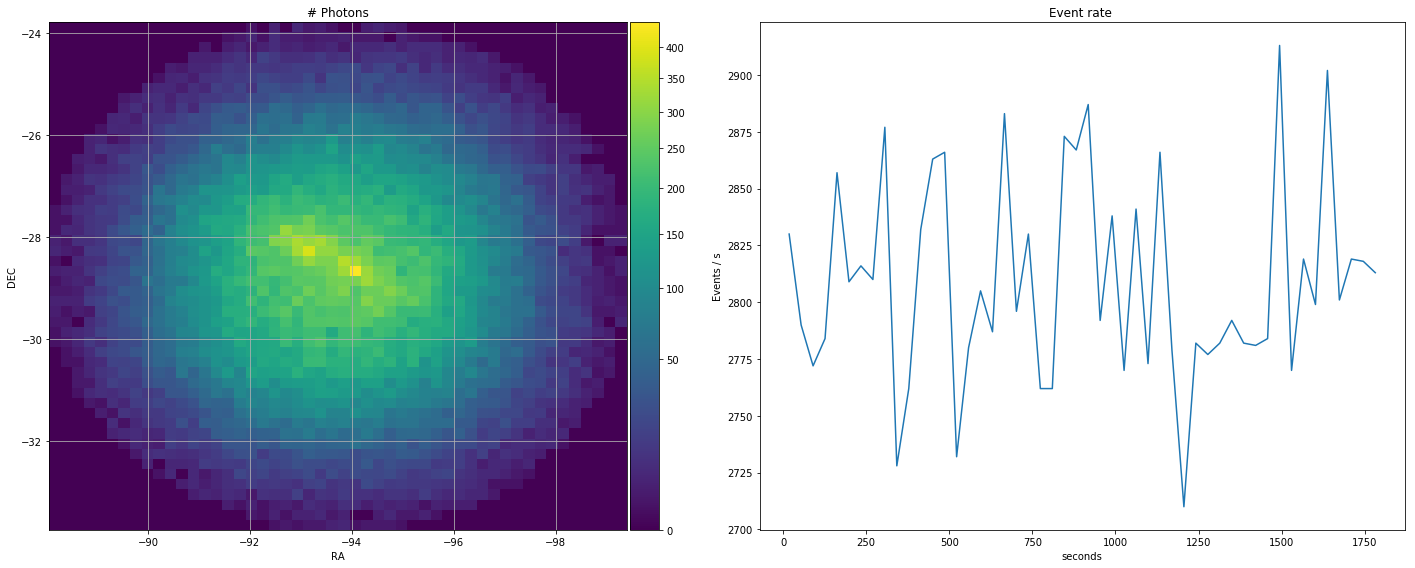

In [12]:
obs.events.peek()

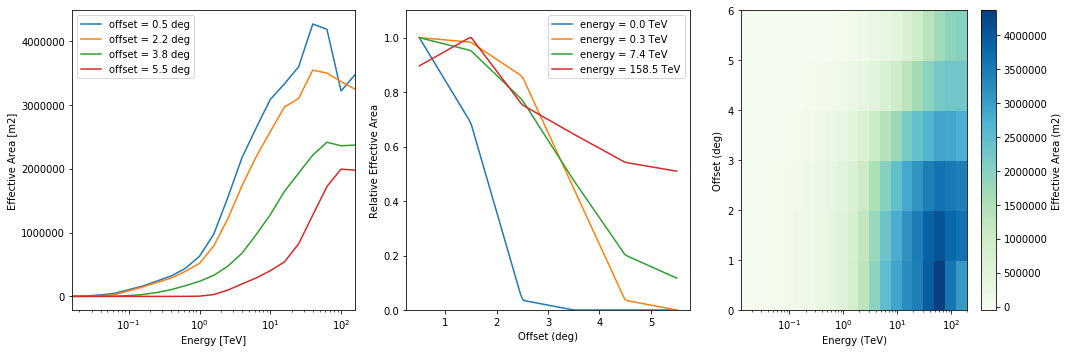

In [13]:
obs.aeff.peek()

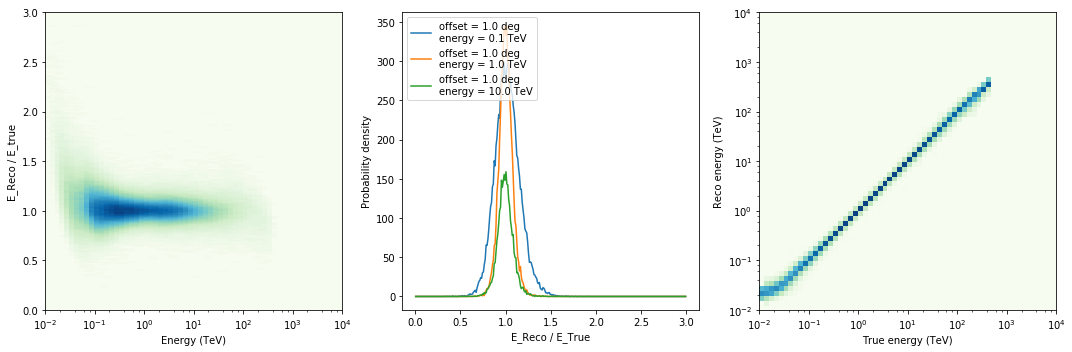

In [14]:
obs.edisp.peek()

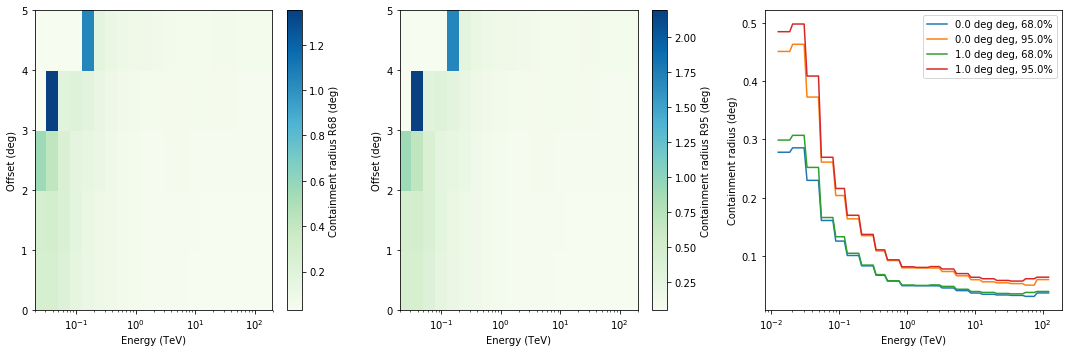

In [15]:
obs.psf.peek()

## Define inputs

Select the target position and define an ON region for the spectral analysis

In [16]:
target_position = SkyCoord(0, 0, unit='deg', frame='galactic')
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [27]:
# Define reference image centered on the target
# xref = target_position.galactic.l.value
# yref = target_position.galactic.b.value
# size = 10 * u.deg
# binsz = 0.02 # degree per pixel
# npix = int((size / binsz).value)

ref_image = SkyImage.empty(
    nxpix=800, nypix=600, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL',
)
print(ref_image)

Name: None
Data shape: (600, 800)
Data type: float64
Data unit: 
Data mean: 0.000e+00
WCS type: ['GLON-TAN', 'GLAT-TAN']



(<matplotlib.figure.Figure at 0x1120f5748>,
 None)

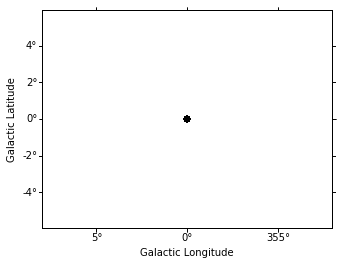

In [28]:
# exclusion = SkyMask.empty_like(ref_image, fill=1)
# exclusion.name = 'exclusion'
exclusion_mask = ref_image.region_mask(on_region)
exclusion_mask.data = 1 - exclusion_mask.data
exclusion_mask.plot()

## Make maps

Standard analysis products: Counts and Significance images

In [29]:
emin = 100 * u.GeV
emax = 100 * u.TeV

bkg_estimator = RingBackgroundEstimator(r_in=0.5 * u.deg, width=0.2 * u.deg)
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=emin, emax=emax,
    background_estimator=bkg_estimator,
    exclusion_mask=exclusion_mask,
)

images = image_estimator.run(observation_list)
images.names

['counts', 'exposure', 'background', 'excess', 'flux']

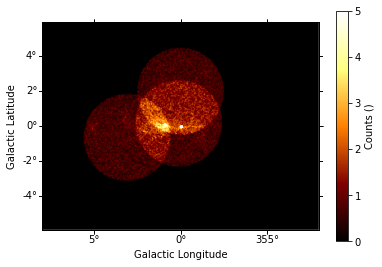

In [31]:
images['counts'].smooth(radius=3).show(add_cbar=True, vmax=5)

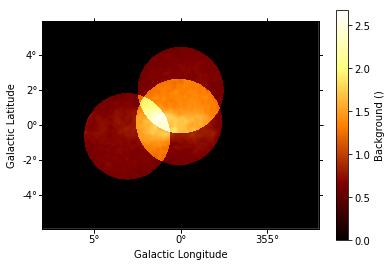

In [32]:
images['background'].show(add_cbar=True)

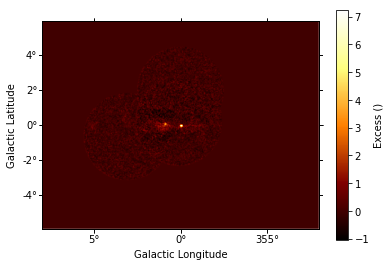

In [33]:
images['excess'].smooth(radius=3).show(add_cbar=True)

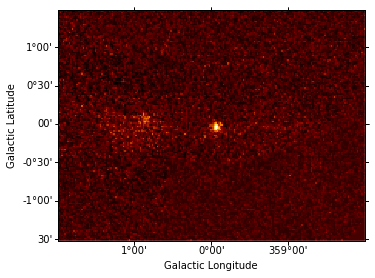

In [34]:
images['excess'].cutout(
    position=SkyCoord(0, 0, unit='deg', frame='galactic'),
    size=(3*u.deg, 4*u.deg),
).smooth(radius=1).show()

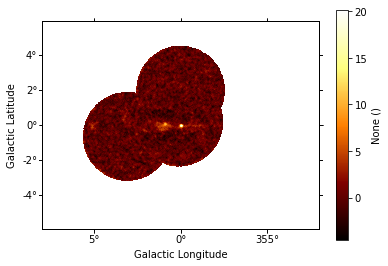

In [35]:
# Significance image
# Just for fun, let's compute it by hand ...
from astropy.convolution import Tophat2DKernel
kernel = Tophat2DKernel(4)
kernel.normalize('peak')

counts_conv = images['counts'].convolve(kernel.array)
background_conv = images['background'].convolve(kernel.array)

from gammapy.stats import significance
significance_image = SkyImage.empty_like(ref_image)
significance_image.data = significance(counts_conv.data, background_conv.data)
significance_image.show(add_cbar=True)

# Spectrum

Standard analysis products: Spectrum and flux points

In [36]:
bkg_method = dict(
    method='reflected',
    exclusion=exclusion_mask,
)

extract = SpectrumExtraction(
    target=on_region,
    obs=observation_list,
    background=bkg_method,
)
extract.run()

UnboundLocalError: local variable 'handle' referenced before assignment

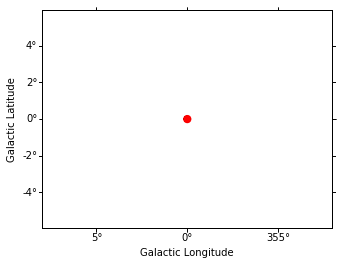

In [37]:
extract.refl.plot()

In [38]:
model = models.PowerLaw(
    index = 2 * u.Unit(''),
    amplitude = 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference = 1 * u.TeV,
)

fit = SpectrumFit(extract.observations, model)
fit.fit()
fit.est_errors()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw
ParameterList
Parameter(name='index', value=1.7753093339576795, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2.133234994318742e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: [[  1.17552452e-03   2.02944894e-15   0.00000000e+00]
 [  2.02944894e-15   3.97004399e-26   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]] 

Statistic: 153.314 (wstat)
Fit Range: [  1.00000000e-02   1.00000000e+02] TeV



In [39]:
# Flux points are computed on stacked observation
stacked_obs = extract.observations.stack()
print(stacked_obs)

ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit = u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit.result[0].model,
)
fpe.compute_points()
fpe.flux_points.table

*** Observation summary report ***
Observation Id: [1398-1320]
Livetime: 0.950 h
On events: 1079
Off events: 23795
Alpha: 0.028
Bkg events in On region: 674.67
Excess: 404.33
Excess / Background: 0.60
Gamma rate: 0.10 1 / min
Bkg rate: 0.16 1 / min
Sigma: 14.07
energy range: 0.01 TeV - 100.00 TeV


dnde,e_min,e_max,dnde_err,e_ref
1 / (m2 s TeV),TeV,TeV,1 / (m2 s TeV),TeV
float64,float64,float64,float64,float64
1.0891202048e-08,1.13646366639,2.44843674682,2.08475968967e-09,1.6681005372
2.21513006142e-09,2.44843674682,5.99484250319,3.84535399654e-10,3.83118684956
3.42988893348e-10,5.99484250319,14.6779926762,7.60039391526e-11,9.3804186664
2.64605891813e-11,14.6779926762,35.938136638,1.22322398663e-11,22.9673617634


(<matplotlib.axes._subplots.AxesSubplot at 0x110cb6d68>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1124f37f0>)

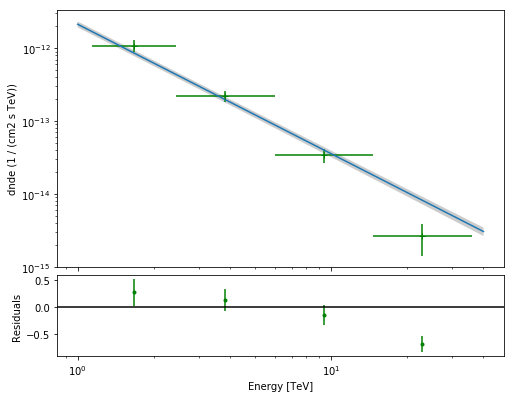

In [40]:
total_result = SpectrumResult(
    model=fit.result[0].model,
    points=fpe.flux_points,
)

total_result.plot(energy_range = [1, 40] * u.TeV,
                 fig_kwargs=dict(figsize=(8,8)),
                 point_kwargs=dict(color='green'))

## What next?

* Give us a few weeks to fix things up with the 1DC data and Gammapy.
* Go explore CTA 1DC!